<a href="https://colab.research.google.com/github/Elignesin/SureStart/blob/main/Feb22_Facial_Gender_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Gender Classification of Facial Images
This notebook will create a classification Convolutional Neural Network to classify the gender of faces in images in a dataset. The dataset comes from https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv, and the CNN in this notebook is adapted in part from https://www.kaggle.com/thanaphatj/gender-classification-of-facial-images-cnn/.  

The data in the notebook and the CSV file is encoded as follows:  
*   Age: range from 1 to 116  
*   Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other  
*   Gender: 0 - male, 1 - female  

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#This helps with plotting in notebooks
%matplotlib inline 

import tensorflow as tf
import keras
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix, classification_report
import random

In [2]:
#Now let's read in the data into a dataframe and look at it
data = pd.read_csv('age_gender.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB
None


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


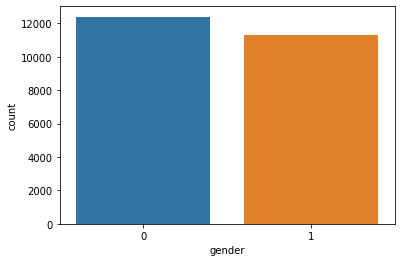

In [3]:
#Let's look at a plot of the gender, because that's what we're going to try to predict first here
sns.countplot(x='gender', data=data)
plt.show()

#### Data Preprocessing Steps

In [4]:
#First, we want to only work with adults, so we're going to drop all columns with age below 16
#This drops about 4000 rows
adult_data = data[data['age'] >= 16]
adult_data.shape

(19877, 5)

In [5]:
#Next, we have to separate out the image data and shape it into numpy arrays of the correct dimensions

#First, we figure out the image dimensions
image1 = len(adult_data['pixels'].iloc[0].split(' '))
dimension = int(image1 ** .5)
img_width=dimension
img_height=dimension

#I'm taking this function from the notebook, then modifying it slightly
def str_to_npArr(x):
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array([int(i)/255 for i in x.split(' ')], dtype="float32")) #converting data to numpy array
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

#Make our image dataset
images = adult_data.iloc[:, 4]
gender = adult_data.iloc[:, 2]

#Reshape our images
images_npArr = str_to_npArr(images)

In [6]:
#Split our training, testing, and validation datasets

#Split out a testing dataset, 15%
train, X_test, trainy, y_test = tts(images_npArr, gender, test_size = 0.15, random_state = 126)
#Split out a validation dataset, 25% of our remaining dataset
X_train, X_val, y_train, y_val = tts(train, trainy, test_size = 0.25, random_state = 126)

print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Validation Set: {X_val.shape}, {y_val.shape}")
print(f"Testing Set: {X_test.shape}, {y_test.shape}")

Training Set: (12671, 48, 48, 1), (12671,)
Validation Set: (4224, 48, 48, 1), (4224,)
Testing Set: (2982, 48, 48, 1), (2982,)


#### Data Augmentation
Here, we're going to do some basic image augmentation on the training data, and also rescale all the X data

In [7]:
#Use ImageDataGenerator to create augmentations, I modified the code in the notebook here for the training data
#I also did the rescaling above so it didn't have to be done down here

data_gen = ImageDataGenerator(rotation_range=25,
                              width_shift_range=.2,
                              brightness_range=[0.75,1.25],
                              zoom_range=[0.8,1.2],
                              height_shift_range=.2,  # randomly shift images vertically 10%
                              horizontal_flip=True,
                              vertical_flip = True# randomly flip images
                              )

#### Building and Training the Model

In [8]:
batch_size = 32
img_height = 48
img_width = 48
input_shape = (img_height, img_width, 1)
n_classes = 2
epochs = 25

In [20]:
#The notebook uses k-fold cross validation, I don't want to
#We're going to build a model with two convolutional layers, three dense layers, and an output layer
model = Sequential()
#First Convolutional Layer
model.add(Conv2D(64, (3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
#Second Convolutional Layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
#Flatten Layer reduces the input to one dimension
model.add(Flatten())
#Dense Layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation='relu'))
#Output Layer with Sigmoid Activation
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 23, 23, 64)        256       
_________________________________________________________________
dropout_20 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 10, 10, 64)       

In [21]:
#Now we'll compile the model
model.compile(optimizer=RMSprop(learning_rate=1e-04), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
#Fit the model
history = model.fit(data_gen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val), steps_per_epoch=X_train.shape[0] // batch_size,
                              verbose=1)

Epoch 1/25
395/395 [==============================] - 76s 189ms/step - loss: 0.6776 - accuracy: 0.5899 - val_loss: 0.8721 - val_accuracy: 0.5376
Epoch 2/25
395/395 [==============================] - 74s 188ms/step - loss: 0.6303 - accuracy: 0.6638 - val_loss: 0.7802 - val_accuracy: 0.5376
Epoch 3/25
395/395 [==============================] - 74s 188ms/step - loss: 0.6261 - accuracy: 0.6608 - val_loss: 0.8042 - val_accuracy: 0.5376
Epoch 4/25
395/395 [==============================] - 74s 188ms/step - loss: 0.6069 - accuracy: 0.6843 - val_loss: 0.7848 - val_accuracy: 0.5376
Epoch 5/25
395/395 [==============================] - 75s 189ms/step - loss: 0.5980 - accuracy: 0.6859 - val_loss: 0.6891 - val_accuracy: 0.5376
Epoch 6/25
395/395 [==============================] - 74s 189ms/step - loss: 0.5994 - accuracy: 0.6864 - val_loss: 0.6895 - val_accuracy: 0.5376
Epoch 7/25
395/395 [==============================] - 75s 189ms/step - loss: 0.5867 - accuracy: 0.7008 - val_loss: 1.1020 - val_ac

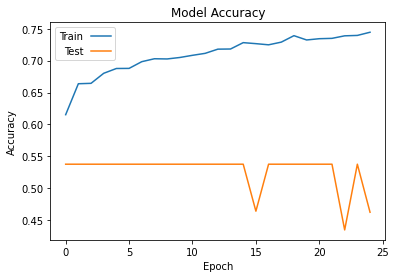

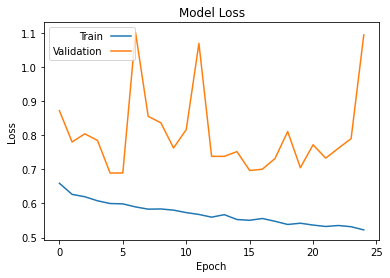

In [23]:
#Now, we want to plot our accuracy and loss for both our validation and training datasets
#This code was provided by my Surestart mentor and has been lightly modified

#Accuracy Curve
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best', markerfirst=False)
#plt.savefig('acc1.png')
plt.show()

#Loss Curve
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best', markerfirst=False)
#plt.savefig('loss1.png')
plt.show()

94/94 [==============================] - 4s 38ms/step - loss: 1.0979 - accuracy: 0.4604


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1609
           1       0.46      1.00      0.63      1373

    accuracy                           0.46      2982
   macro avg       0.23      0.50      0.32      2982
weighted avg       0.21      0.46      0.29      2982



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


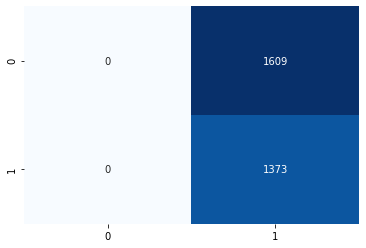

In [24]:
#Now, we want to make predictions on our test dataset
#All this code is taken from the notebook, it's very simple and I'm not trying to reinvent the wheel here
model.evaluate(X_test, y_test)

y_pred = model.predict_classes(X_test)

print(classification_report(y_test, y_pred))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt='d');